In [ ]:
# new script for generating the non-Gaussian tables 
# the new version uses panda dataframes and organizes a few blocks into one to make the code cleaner
# modified in 2024: 2024/05/02
# modified in 2025: 2024/12/23
# modified: 2025/09/04: add functions to adjust for different definitions of cloud predictors

# in 2025 version:
# (1) for model/sym cloud: use nobc cloud
# (2) redefine the cloud bins

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [2]:
### namelist for the notebook:
instrument = 'atms'
channel    = 'ch18'
expid      = 'v3_hydro'                 # which experiment OmF is used to derive the non-Gaussian table
time       = '2024070500_2024073012'    # during which the OmF data are compiled
stdev_from = f'OmF_{expid}'
predictor  = 'sym_cld'                  # currently, only symmetric cloud is used 
                                        # can explore other options, but needs to be tuned in the future)

# define the cloud predictor for each channel:
if instrument == 'amsua':
    if channel in ('ch1','ch2','ch3'):
        cld_pred = 'clw'
    elif channel in ('ch4','ch5','ch15'):
        cld_pred = 'ch3'
elif instrument == 'atms':
    if channel in ('ch1','ch2','ch3'):
        cld_pred = 'clw'
    elif channel in ('ch4','ch5','ch6','ch16','ch17'):
        cld_pred = 'ch3'
    elif channel in ('ch18','ch19','ch20','ch21','ch22'):
        cld_pred = 'si1617'

datadir   = f'/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/compile_radstats/csv_files/{expid}' # where the compiled radstats (.csv file) is 
csv_fn    = f'omfges_stats_{instrument}_{channel}_{time}.csv'
outputdir = f'/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/non_Gaussian_tables'         # where the output of the table is
output_fn = f'nonGaussian_table_{instrument}_{channel}_{predictor}_{cld_pred}_{expid}'

save_fig  = True    # whether to save intermediate figures 
fig_dir   = f'/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/python_codes/figures/tables/{expid}'
if save_fig:
    os.makedirs(fig_dir, exist_ok=True)

In [3]:
### tuning parameters for constructing the non-Gaussian tables

def nonGaussian_params(instrument, channel, predictor, cld_pred):

    print(f'{instrument}-{channel}: cld_pred = {cld_pred}')

    # cloud predictor bins def:
    if cld_pred == 'clw':
        cloud_edge = np.array([0.00, 0.025, 0.050, 0.075, \
                               0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40,\
                               0.50, 0.60, 0.80, 1.00])
    elif cld_pred == 'ch3':
        cloud_edge = np.array([0.0, 0.5, 1.0, 2.0, \
                               3.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5,\
                               20.0, 25.0, 30.0, 50.0])
    elif cld_pred == 'si1617':
        cloud_edge = np.array([0.0, 0.5, 1.0, 2.0, \
                               3.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5,\
                               20.0, 25.0, 30.0, 50.0])

    print(f'{instrument}-{channel}: cloud edge = {cloud_edge}')

    
    # regrid pdf range:
    if predictor in ('sym_cld', 'obs_cld'):
        if instrument == 'amsua':
            if channel in ('ch1','ch2','ch15'):
                bdy_regrid = 60;     dx_regrid  = 0.1
            elif channel in ('ch3'):
                bdy_regrid = 40;     dx_regrid  = 0.05       
            elif channel in ('ch4'):
                bdy_regrid = 15;     dx_regrid  = 0.02
            elif channel in ('ch5'):
                bdy_regrid = 5;      dx_regrid  = 0.005

        if instrument == 'atms':
            if channel in ('ch1','ch16'):
                bdy_regrid = 60;     dx_regrid  = 0.1
            elif channel in ('ch2'):
                bdy_regrid = 80;     dx_regrid  = 0.1                
            elif channel in ('ch3'):
                bdy_regrid = 40;     dx_regrid  = 0.05
            elif channel in ('ch4'):
                bdy_regrid = 25;     dx_regrid  = 0.025
            elif channel in ('ch5'):
                bdy_regrid = 8;      dx_regrid  = 0.01
            elif channel in ('ch6'):
                bdy_regrid = 5;      dx_regrid  = 0.01
            elif channel in ('ch17','ch18','ch19','ch20','ch21'):
                bdy_regrid = 30;     dx_regrid  = 0.1
            elif channel in ('ch22'):
                bdy_regrid = 30;     dx_regrid  = 0.05

    print(f'{instrument}-{channel}: re-grid range, dx = {bdy_regrid}, {dx_regrid}')

    min_allow_pdf = 2.5e-4
    max_allowed_stdev = 100
    
    # fitted polynomial order
    if predictor in ['obs_cld', 'sym_cld']:
        if instrument == 'amsua':
            if channel in ('ch1','ch2','ch3','ch4','ch5','ch15'):
                poly_dim = 12*np.ones(len(cloud_edge)-1)
                poly_dim[6:] = 6
                poly_dim[11:] = 4

        if instrument == 'atms':
            if channel in ('ch1','ch2','ch3','ch4','ch5','ch6'):
                poly_dim = 12*np.ones(len(cloud_edge)-1)
                poly_dim[-6:-3] = 6
                poly_dim[-3:] = 4

            elif channel in ('ch16','ch17'):
                poly_dim = 12*np.ones(len(cloud_edge)-1)
                poly_dim[-6:-3] = 6
                poly_dim[-3:] = 4

            elif channel in ('ch18','ch19','ch20','ch21','ch22'):
                poly_dim = 16*np.ones(len(cloud_edge)-1)
                poly_dim[-6:-3] = 16
                poly_dim[-3:] = 12                

    print(f'{instrument}-{channel}: poly dimension = {poly_dim}')
                
    # parameters for defining the tails
    critical_cost_val = 5.5
    extrap_slope      = 0.5 
                
    print(f'{instrument}-{channel}: critical_cost_val, extrap_slope = {critical_cost_val}, {extrap_slope}')

    # low-resolution output:
    coarse_ratio  = 20

    print(f'{instrument}-{channel}: coarse_ratio = {coarse_ratio}')


    return cloud_edge, bdy_regrid, dx_regrid, min_allow_pdf, poly_dim, critical_cost_val, extrap_slope, max_allowed_stdev, coarse_ratio

In [4]:
# summary of the tuning parameters
print(f' === summary of tuning parameters for {instrument}-{channel} === ')
cloud_edge, bdy_regrid, dx_regrid, min_allow_pdf, poly_dim, critical_cost_val, extrap_slope, max_allowed_stdev, coarse_ratio = \
          nonGaussian_params(instrument, channel, predictor, cld_pred)

 === summary of tuning parameters for atms-ch18 === 
atms-ch18: cld_pred = si1617
atms-ch18: cloud edge = [ 0.   0.5  1.   2.   3.5  5.   7.5 10.  12.5 15.  17.5 20.  25.  30.
 50. ]
atms-ch18: re-grid range, dx = 30, 0.1
atms-ch18: poly dimension = [16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 12. 12. 12.]
atms-ch18: critical_cost_val, extrap_slope = 5.5, 0.5
atms-ch18: coarse_ratio = 20


In [5]:
### read omf csv (slow, reading large file)
fn = f'{datadir}/{csv_fn}'
df = pd.read_csv(fn)

# screen the data:
dfs = df[abs(df['omf']) < 1e3]

In [6]:
### sort the data based on regions 
# (now: all samples over the ocean are used to generate the non-Gaussian table)
regions=['sea']
lats   =['Global']

#regions=['land','sea']
#lats   =['Global','90S-60S','60S-40S','40S-20S','20S-0','0-20N','20N-40N','40N-60N','60N-90N']

adf={} # "a"nalysis "d"ata "f"rame

for rg in regions:
    adf[rg] = {}  # Initialize the nested dictionary for each experiment
    if rg == 'land':
        dftmp = dfs.loc[ dfs['fland']>=0.99 ]
    elif rg == 'sea':
        dftmp = dfs.loc[ dfs['fwater']>=0.99 ]
        
    for lat in lats:
        if lat == 'Global':
            adf[rg][lat] = dftmp
        elif lat == '90S-60S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-60) & (dftmp['lat']>-90) ]
        elif lat == '60S-40S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-40) & (dftmp['lat']>-60) ]
        elif lat == '40S-20S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-20) & (dftmp['lat']>-40) ]
        elif lat == '20S-0':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=0) & (dftmp['lat']>-20) ]
        elif lat == '0-20N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=20) & (dftmp['lat']>0) ]
        elif lat == '20N-40N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=40) & (dftmp['lat']>20) ]
        elif lat == '40N-60N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=60) & (dftmp['lat']>40) ]
        elif lat == '60N-90N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=90) & (dftmp['lat']>60) ]

In [ ]:
dftmp.keys()

In [22]:
# divide the samples into cloud categories based on their cloud amount

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

dftmp = adf['sea']['Global']
n_cat = len(cloud_edge)-1

nginfo = {}; # dictionary for storing all the non-Gaussian information
for i in range(n_cat):
    print("processing the ",i+1,"-th cloud bin...")
    nginfo[i] = {} # initialize the nested dictionary

    if cld_pred == 'clw':
        catdf = dftmp.loc[ ( 0.5*(dftmp['clw_obs']+dftmp['clw_bg_nobc']) >= cloud_edge[i]   )& \
                           ( 0.5*(dftmp['clw_obs']+dftmp['clw_bg_nobc']) <  cloud_edge[i+1] )]  # "cat"-egory dataframe
#        catdf = dftmp.loc[ ( 0.5*(dftmp['clw_obs']+dftmp['clw_bg']) >= cloud_edge[i]   )& \
#                           ( 0.5*(dftmp['clw_obs']+dftmp['clw_bg']) <  cloud_edge[i+1] )]  # "cat"-egory dataframe
    elif cld_pred == 'ch3':
        catdf = dftmp.loc[ ( 0.5*(dftmp['cld_ch3_obs']+dftmp['cld_ch3_bg']) >= cloud_edge[i]   )& \
                           ( 0.5*(dftmp['cld_ch3_obs']+dftmp['cld_ch3_bg']) <  cloud_edge[i+1] )]  # "cat"-egory dataframe        
    elif cld_pred == 'si1617':
        catdf = dftmp.loc[ ( 0.5*(dftmp['si_16_17_obs']+dftmp['si_16_17_bg']) >= cloud_edge[i]   )& \
                           ( 0.5*(dftmp['si_16_17_obs']+dftmp['si_16_17_bg']) <  cloud_edge[i+1] )]  # "cat"-egory dataframe

        
    # === save some basic statistics:
    ndata = catdf.shape[0]
    nginfo[i]['count'] = ndata
    nginfo[i]['mean']  = catdf['omf'].mean()
    nginfo[i]['stdev'] = catdf['omf'].std()
    
    # cloud marginal pdfs (not used)
    #axis_cloud = np.arange(-1,1+0.1, 0.05)
    #hist_obs_cld, _  = np.histogram(catdf['clw_obs'], bins=axis_cloud, density=True)
    #hist_bkg_cld, _  = np.histogram(catdf['clw_bg_nobc'] , bins=axis_cloud, density=True)
    #hist_diff_cld, _ = np.histogram(catdf['clw_obs'] - catdf['clw_bg_nobc'], bins=axis_cloud, density=True)
    
    # === save the cloud PDF info:
    #nginfo[i]['axis_cloud'] = 0.5*( axis_cloud[1:] + axis_cloud[:-1])
    #nginfo[i]['hist_obs_cld'] = hist_obs_cld
    #nginfo[i]['hist_bkg_cld'] = hist_bkg_cld
    #nginfo[i]['hist_diff_cld'] = hist_diff_cld

    # omf marginal pdfs:
    # need to define the x-axis for the histogram of omf (each cat is different)
    q1 = catdf['omf'].quantile(0.25)
    q3 = catdf['omf'].quantile(0.75)
    dx_tmp = 2*(q3-q1)/ndata**(1/3)
    
    inflation = 3
    domf_init = 0.05 # a first-guess d(omf)
    dx_omf = np.ceil(inflation*dx_tmp/domf_init)*domf_init
    
    # determine the max/min value based on the above dx_omf
    max_val = ( np.ceil(max(catdf['omf'])/dx_omf)+5)*dx_omf
    min_val = (np.floor(min(catdf['omf'])/dx_omf)-5)*dx_omf
    axis_omf = np.arange(min_val, max_val+dx_omf, dx_omf)
    
    # generate the histogram
    hist_omf, _ = np.histogram(catdf['omf'], bins=axis_omf, density=True)
    
    # regrid the pdfs onto the same grid 
    regrid = np.arange(-bdy_regrid, bdy_regrid+dx_regrid, dx_regrid)

    xp = 0.5*( axis_omf[1:] + axis_omf[:-1])
    yp = hist_omf
    hist_regrid = np.interp(regrid, xp, yp)

    # also calculate the cost-function:
    tmp0 = hist_regrid.copy()       # very important to copy the array here, otherwise the next line will replace the values in hist_omf_regrid_cat
    tmp0[np.where(tmp0<=min_allow_pdf)] = 0.0
    cost_fn = -np.log(tmp0)
    cost_fn[np.isinf(cost_fn)] = np.nan
    
    # === save the cloud PDF info:
    nginfo[i]['critical_cost_val'] = critical_cost_val
    nginfo[i]['cloud_edge'] = cloud_edge[i:i+2]
    nginfo[i]['dx_omf'] = dx_regrid
    nginfo[i]['axis_omf'] = regrid
    nginfo[i]['hist_omf'] = hist_regrid
    nginfo[i]['cost_fn']  = cost_fn

processing the  1 -th cloud bin...
processing the  2 -th cloud bin...
processing the  3 -th cloud bin...
processing the  4 -th cloud bin...
processing the  5 -th cloud bin...
processing the  6 -th cloud bin...
processing the  7 -th cloud bin...
processing the  8 -th cloud bin...
processing the  9 -th cloud bin...
processing the  10 -th cloud bin...
processing the  11 -th cloud bin...
processing the  12 -th cloud bin...
processing the  13 -th cloud bin...
processing the  14 -th cloud bin...


Directory '/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/python_codes/figures/tables/v3_hydro/omf_pdf/atms/ch18' created.


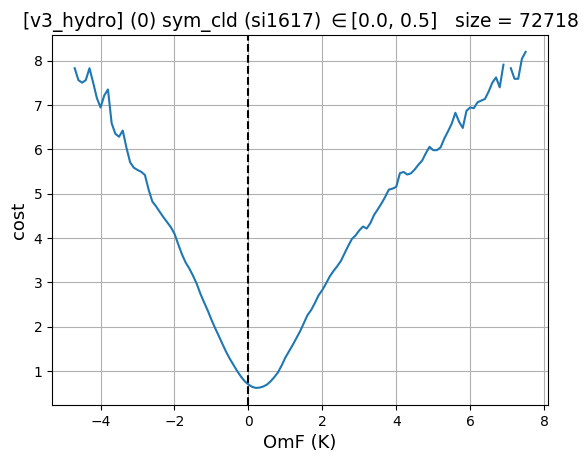

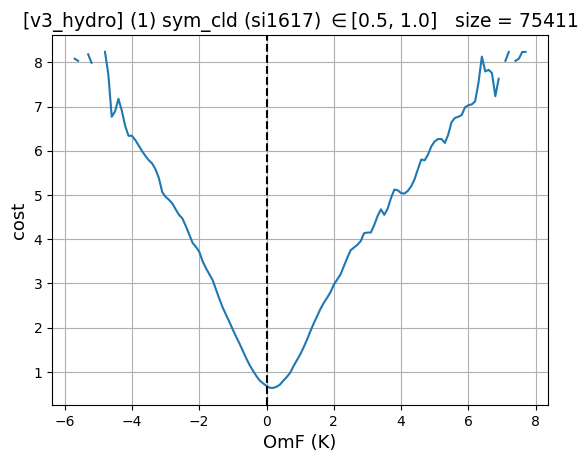

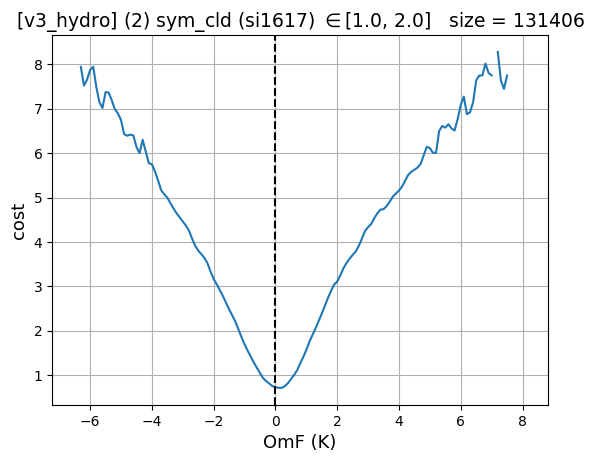

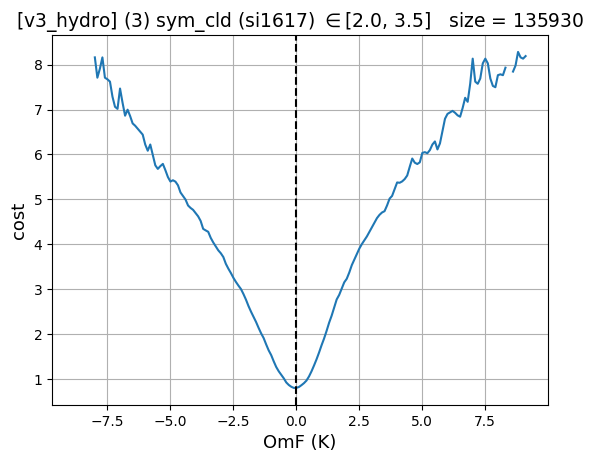

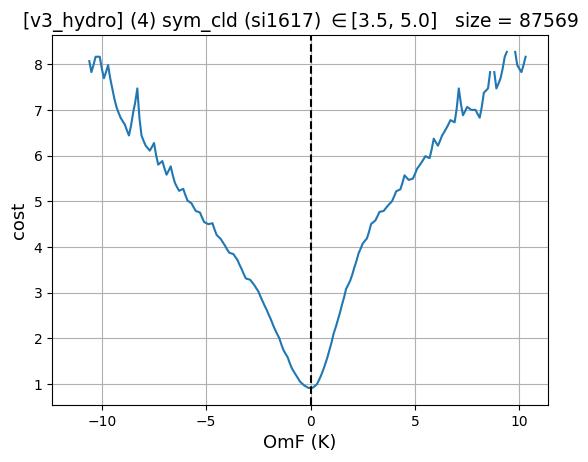

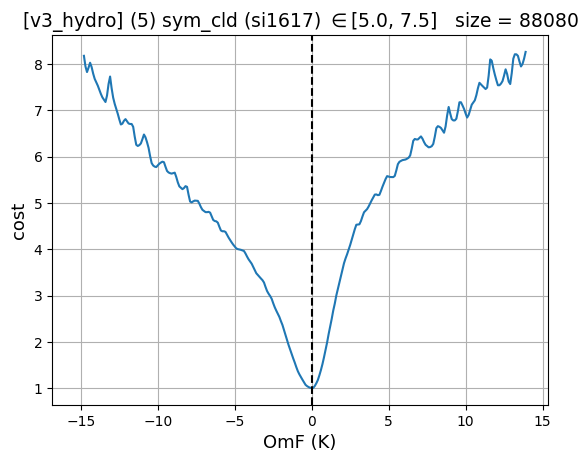

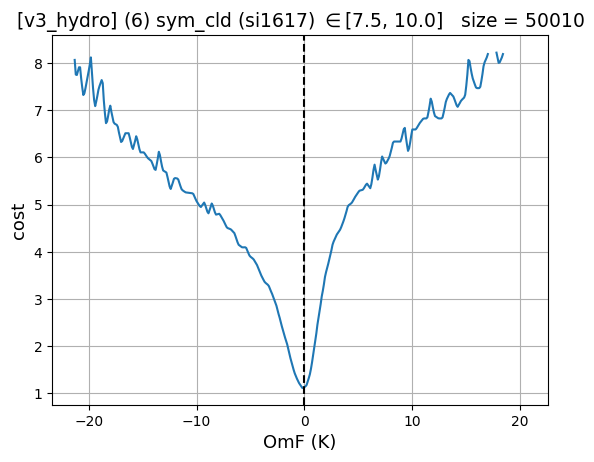

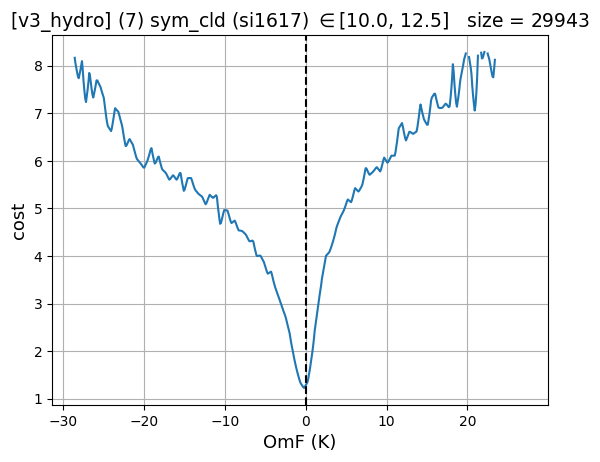

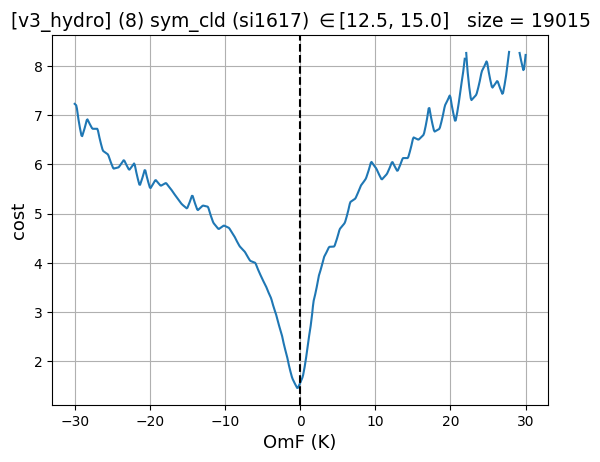

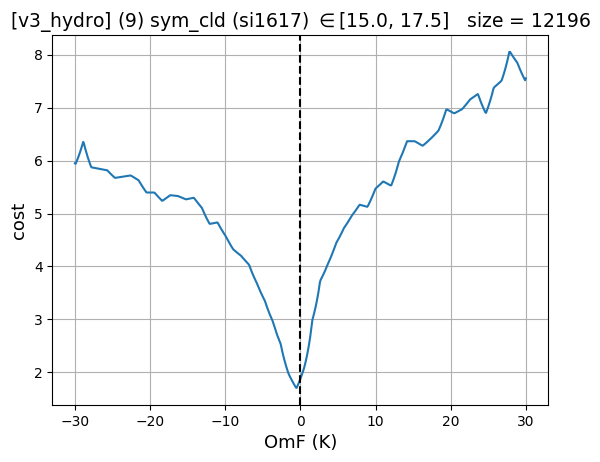

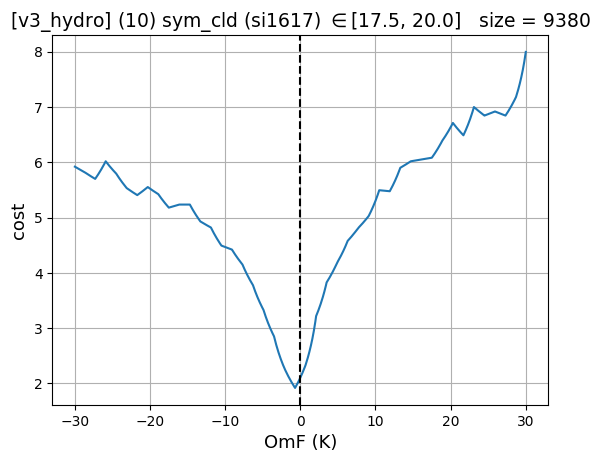

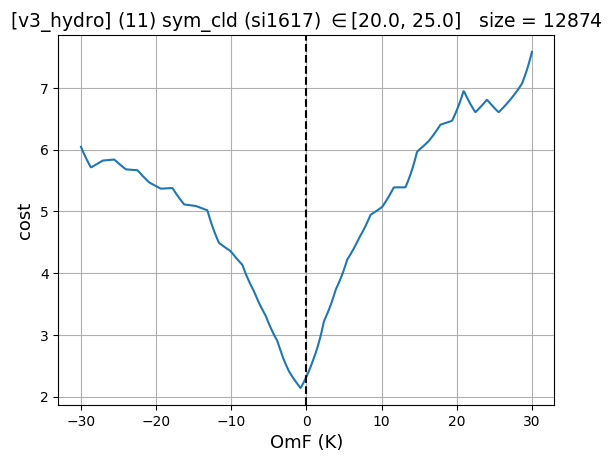

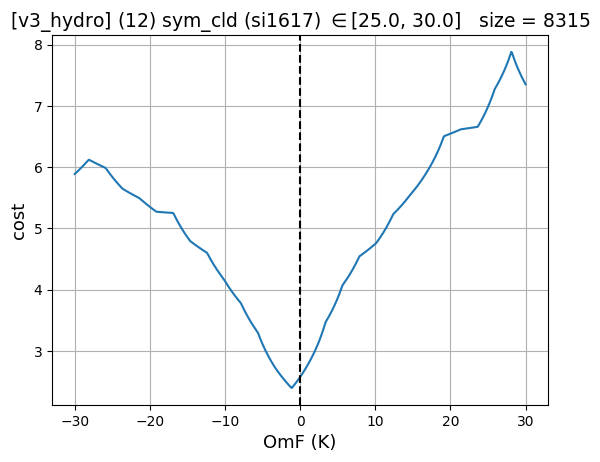

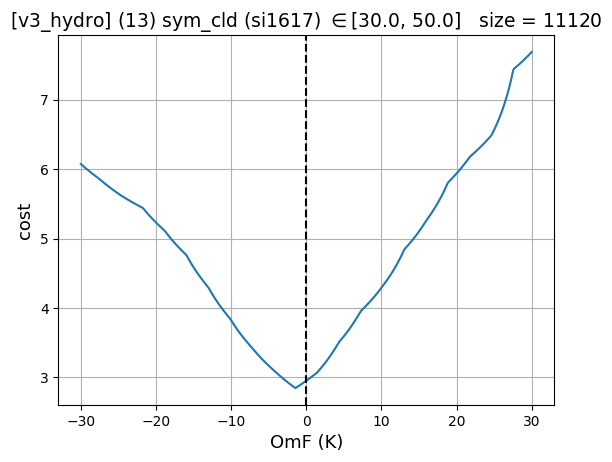

In [23]:
# check if the regrid pdfs look ok:

fig_subdir = f'{fig_dir}/omf_pdf/{instrument}/{channel}'

if save_fig:
    os.makedirs(fig_subdir, exist_ok=True)
    print(f"Directory '{fig_subdir}' created.")

for i in range(n_cat):
    plt.plot(regrid, nginfo[i]['cost_fn'])
    plt.axvline(x=0, color='black', linestyle='--', label='Vertical Line at x=0')
    #plt.xlim([-70,70])
    plt.grid(True)
    plt.xlabel('OmF (K)',fontsize=13)
    plt.ylabel('cost'   ,fontsize=13)
    plt.title(rf"[{expid}] ({i}) {predictor} ({cld_pred}) $\in$[{cloud_edge[i]}, {cloud_edge[i+1]}]   size = {nginfo[i]['count']}",fontsize=13.5)
    
    if save_fig:
        plt.savefig(f"{fig_subdir}/omfpdf_{expid}_{instrument}_{channel}_{predictor}_{cld_pred}_{cloud_edge[i]}_{cloud_edge[i+1]}.png")

    plt.show()


In [ ]:
nginfo[7]['cost_fn']

In [15]:
### Polynomial fit to the cost-functions (variable poly fit )

# Define the polynomial function
def poly_func(x, *coefficients):
    return np.polyval(coefficients[::-1], x)

# Fit a polynomial with a positive constant term
fitted_cost_fn = []
fitted_coeff   = []
for i in range(n_cat):
    initial_guess = np.ones(int(poly_dim[i]+1))  # Adjust the length based on the polynomial degree
    bounds = (np.full(int(poly_dim[i]+1), -np.inf), np.full(int(poly_dim[i]+1), np.inf)) 
    
    #valid_idx = ~np.isnan(nginfo[i]['cost_fn'])
    valid_idx = (~np.isnan(nginfo[i]['cost_fn'])) & (nginfo[i]['cost_fn']<critical_cost_val+1) # add a little margin
    
    coefficients, covariance = curve_fit(poly_func, nginfo[i]['axis_omf'][valid_idx], nginfo[i]['cost_fn'][valid_idx], p0=initial_guess, bounds=bounds)
    tmp = poly_func(regrid, *coefficients)
    tmp[~valid_idx] = np.nan  
    nginfo[i]['fitted_cost_fn'] = tmp
    nginfo[i]['fitted_coeff'] = coefficients

Directory '/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/python_codes/figures/tables/v3_hydro/fitted_omf_pdf/atms/ch18' created.


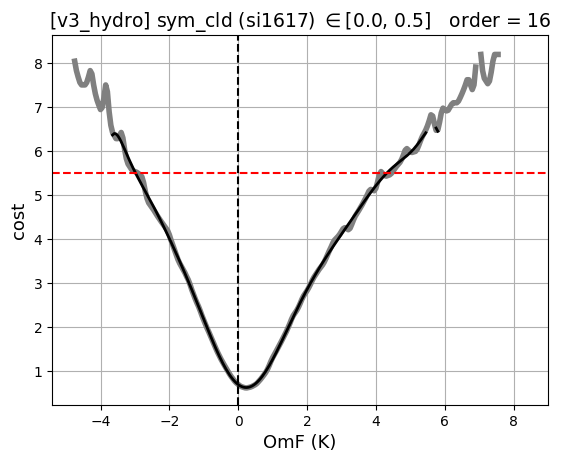

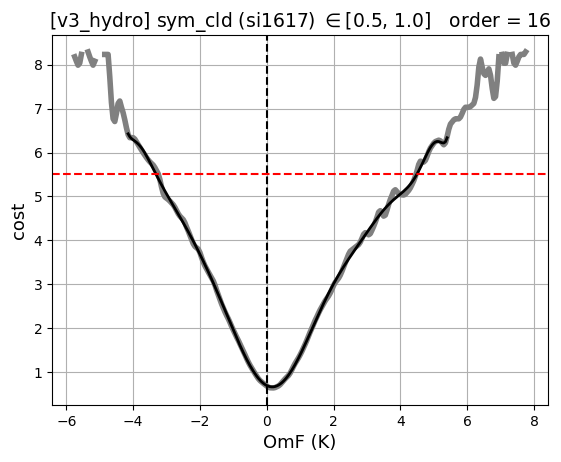

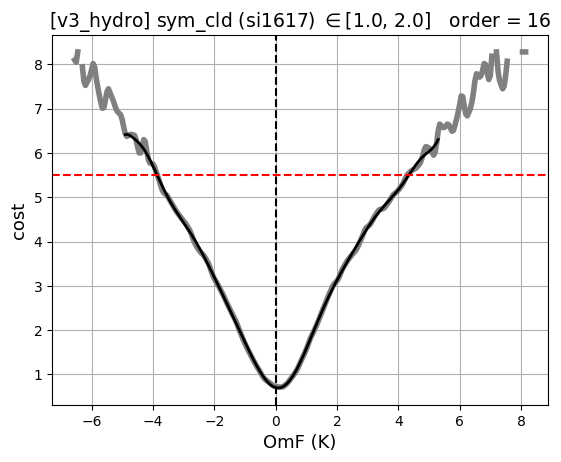

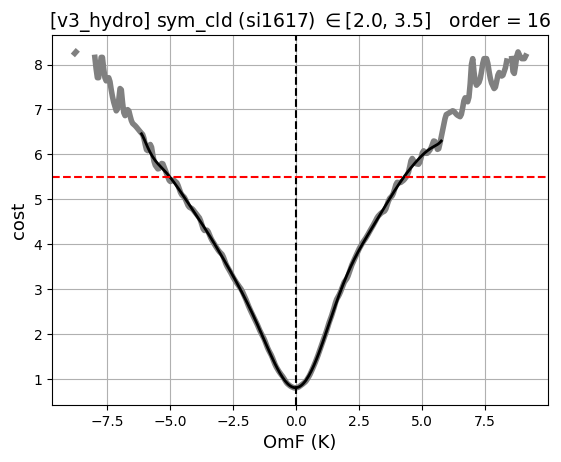

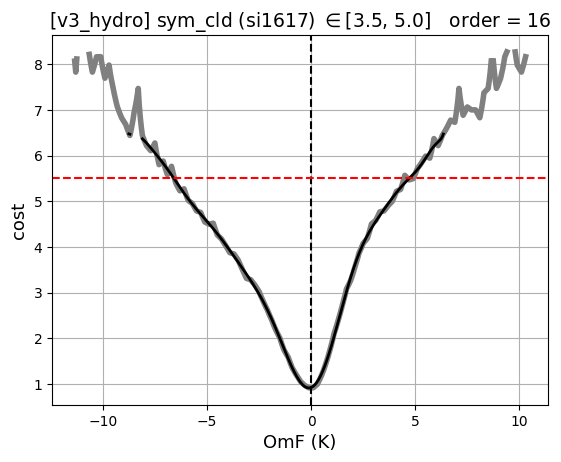

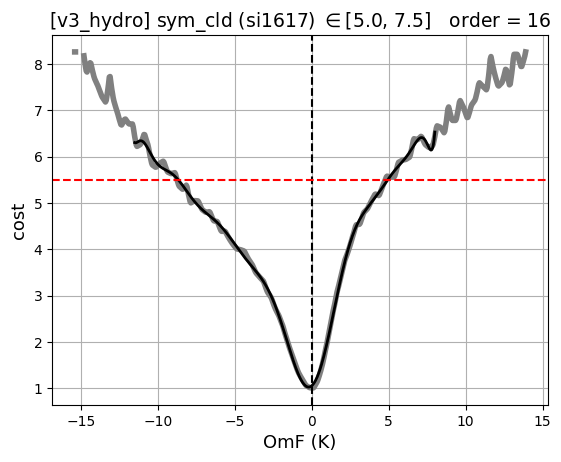

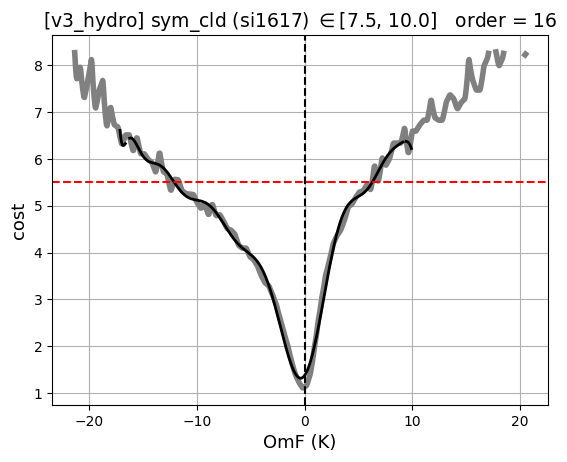

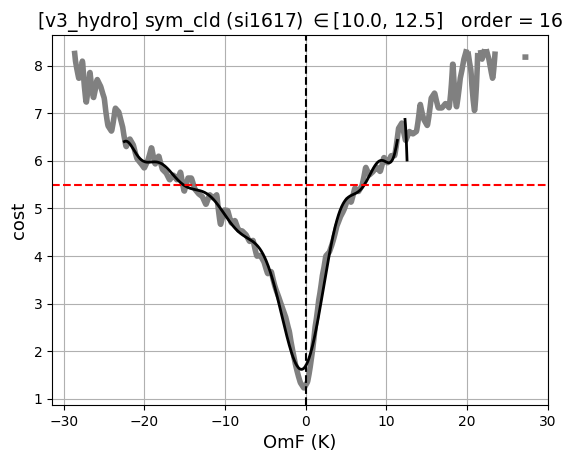

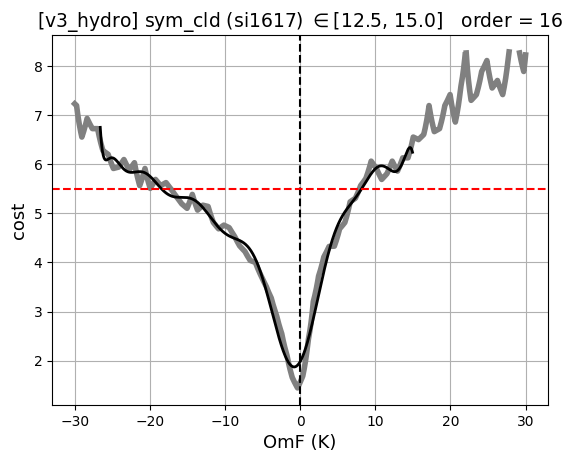

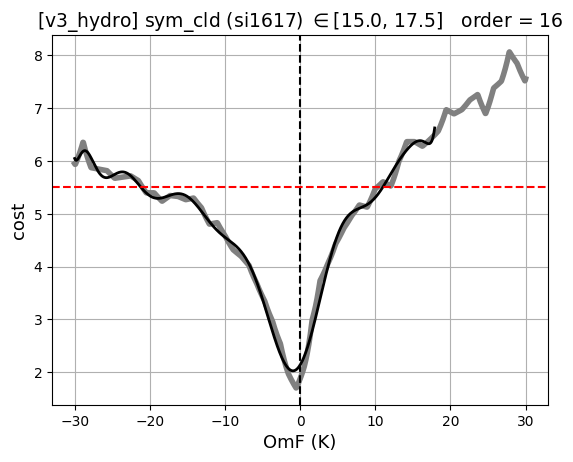

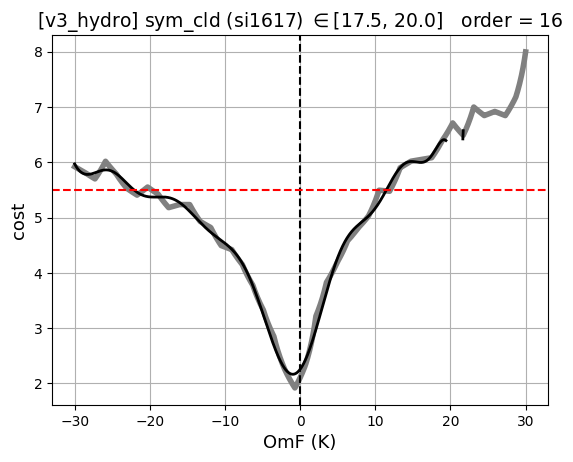

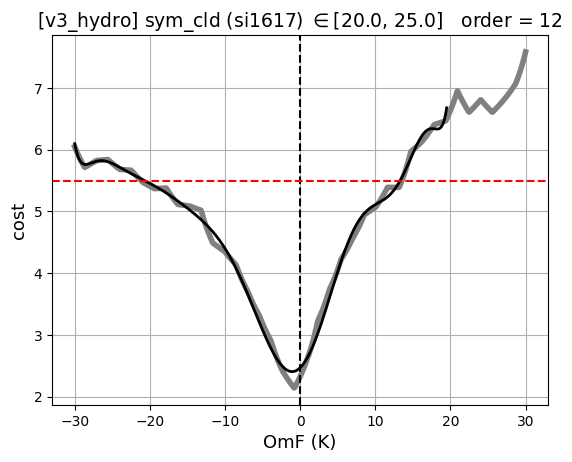

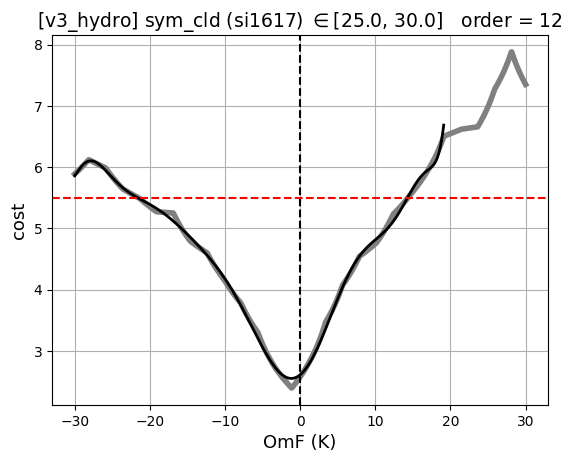

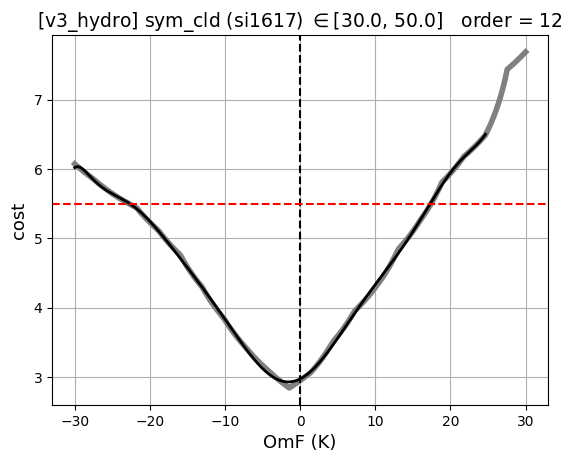

In [16]:
# check if the fitted cost-functions are valid:

fig_subdir = f'{fig_dir}/fitted_omf_pdf/{instrument}/{channel}'

if save_fig:
    os.makedirs(fig_subdir, exist_ok=True)
    print(f"Directory '{fig_subdir}' created.")

for i in range(n_cat):
    plt.plot(regrid, nginfo[i]['cost_fn'], color='gray', linewidth=4)
    plt.plot(regrid, nginfo[i]['fitted_cost_fn'], color='black', linewidth=2)
    plt.axvline(x=0, color='black', linestyle='--', label='Vertical Line at x=0')
    plt.axhline(y=critical_cost_val, color='red', linestyle='--')
    
    plt.xlabel('OmF (K)',fontsize=13)
    plt.ylabel('cost'   ,fontsize=13)
    plt.title(rf"[{expid}] {predictor} ({cld_pred}) $\in$[{cloud_edge[i]}, {cloud_edge[i+1]}]   order = {int(poly_dim[i])}",fontsize=13.5)
    plt.grid(True)

    if save_fig:
        plt.savefig(f"{fig_subdir}/fittedomfpdf_{expid}_{instrument}_{channel}_{predictor}_{cld_pred}_{cloud_edge[i]}_{cloud_edge[i+1]}.png")

    plt.show()  


In [27]:
### identify the mode 
# identify the 'average' mode from regridded pdf (should be the same as the original histogram)

def find_intersections(x_values, y_values):
    # Find indices where y_values change sign (cross y=0)
    sign_changes = np.where(np.diff(np.sign(y_values)))[0]

    # Interpolate to find x-values at sign changes
    x_intersections = np.interp(0, y_values[sign_changes], x_values[sign_changes])

    return x_intersections


for i in range(n_cat):
    fg_top_indices = np.argsort(nginfo[i]['hist_omf'])[-1:]  # used as a first-guess
    min_value      = np.sort(nginfo[i]['fitted_cost_fn'][int(fg_top_indices-200):int(fg_top_indices+200)])[0]    
    min_value_idx  = np.where(nginfo[i]['fitted_cost_fn'] == min_value)
    mode_value     = nginfo[i]['axis_omf'][min_value_idx]
    #top_indices    = np.argsort(fitted_cost_fn[i])[:num_avg_pts]
    #avg_idx_of_top = np.mean(regrid[top_indices]) 
    
    nginfo[i]['mode']     = mode_value
    nginfo[i]['mode_idx'] = find_intersections(np.arange(0,len(nginfo[i]['axis_omf'])), nginfo[i]['axis_omf']-mode_value)

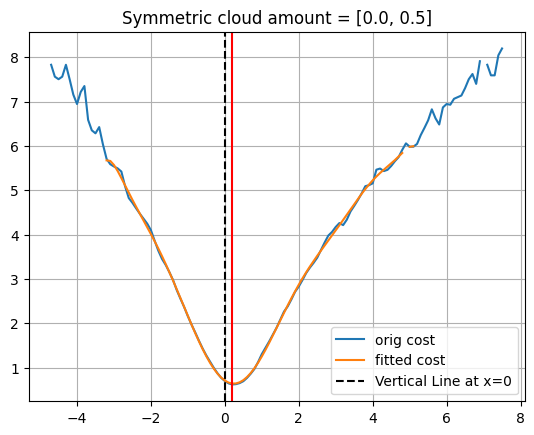

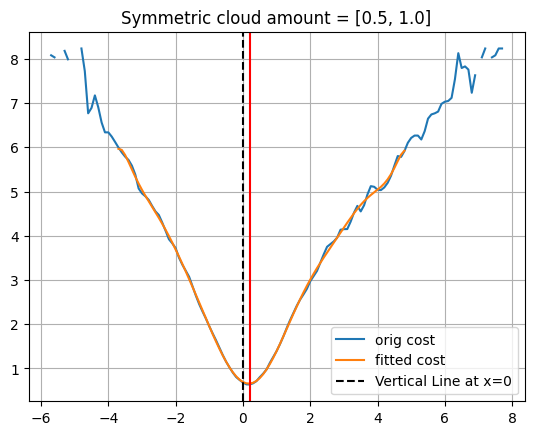

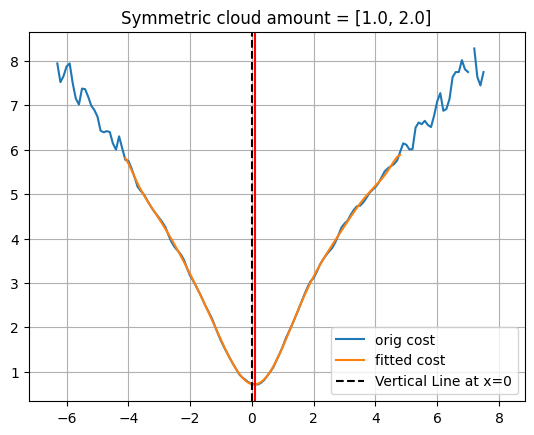

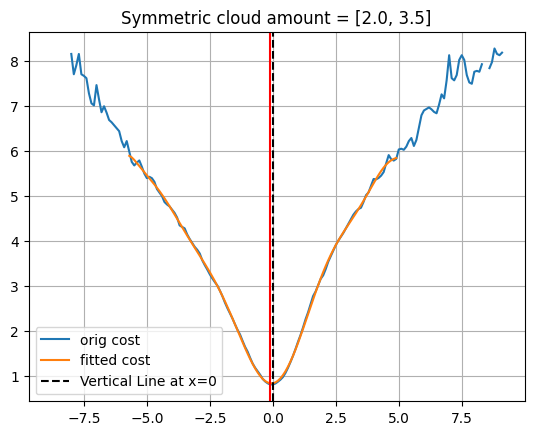

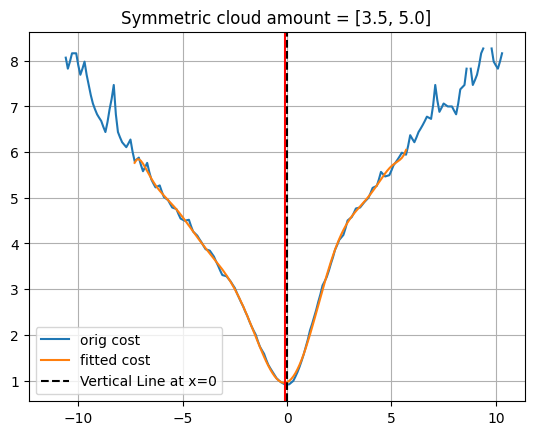

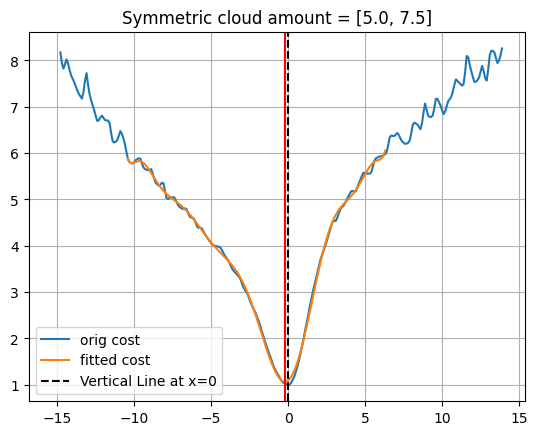

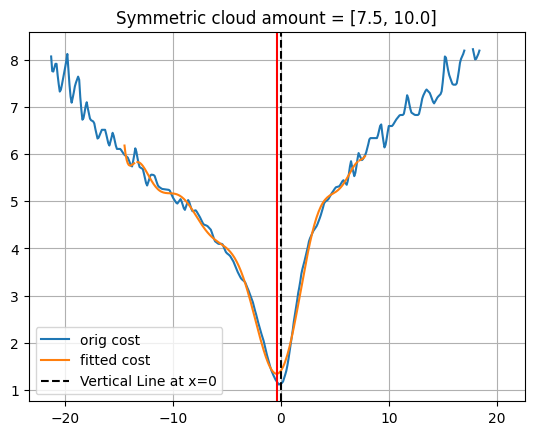

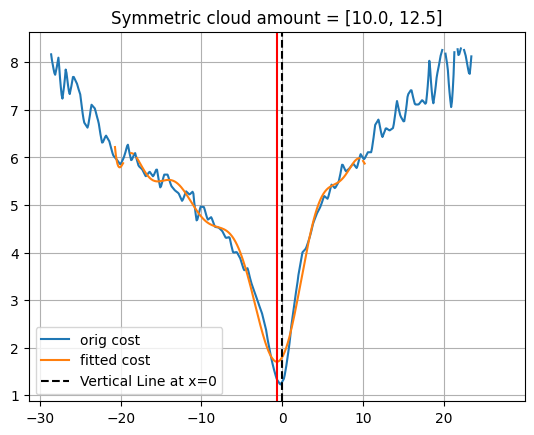

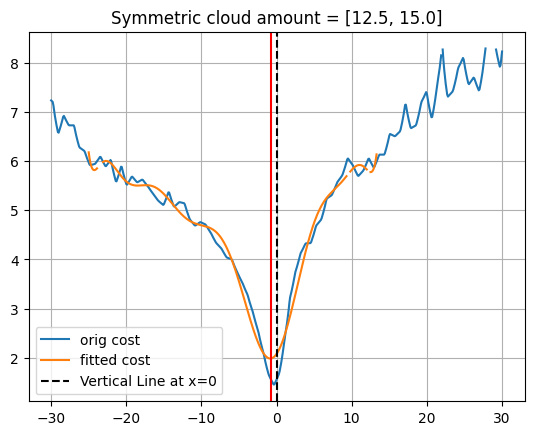

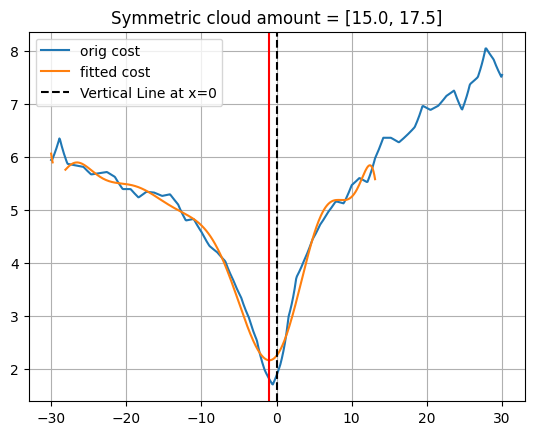

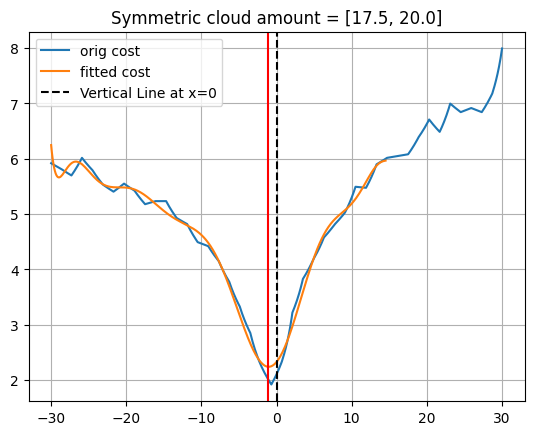

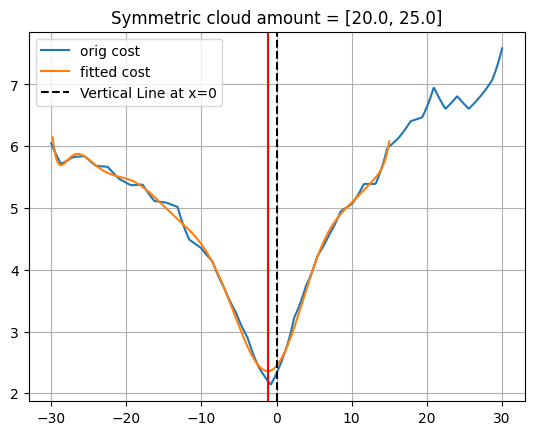

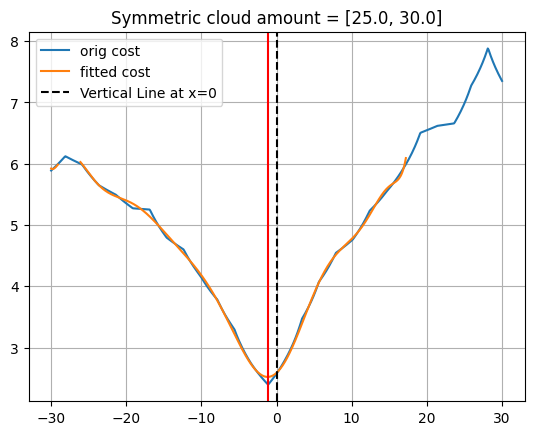

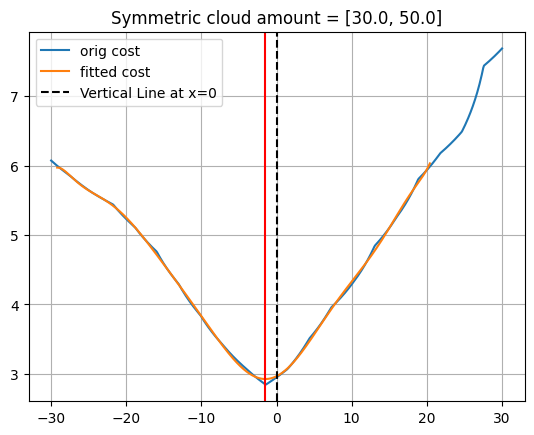

In [28]:
# check if the mode is valid

for i in range(n_cat):
    plt.plot(regrid, nginfo[i]['cost_fn'], label='orig cost')
    plt.plot(regrid, nginfo[i]['fitted_cost_fn'], label ='fitted cost')
    plt.axvline(x=0, color='black', linestyle='--', label='Vertical Line at x=0')
    plt.axvline(nginfo[i]['mode'], color='red')
    #plt.xlim([-70,70])
    plt.grid(True)
    plt.legend()
    plt.title(f'Symmetric cloud amount = [{cloud_edge[i]}, {cloud_edge[i+1]}]')
    plt.show()  

In [31]:
### estimate the standard deivation grid-by-grid -- hybrid method (new method: 2023/11/20)
# when far away from the mode, try to derive the analytical solution
# when close to the mode (or to the boundary), use regression method

# Define derivative of a polynomial:
# note that the input coefficients is from low order to high order [a0, a1, a2,...,an]
# while the final_coeff is from high order to low order [a0, a1, a2,...,an]
def local_derivative(x, coefficients):
    tmp = coefficients.copy()
    new_coeff   = tmp[-1:0:-1]
    final_coeff = new_coeff*np.arange(len(coefficients)-1,0,-1)
    return np.polyval(final_coeff, x)


estimate_sig_cat = []

# parameters for regression method:
#regression_range    = 1.5     # when |x-mode|<regression_range
regression_range    = 3       # when |x-mode|<regression_range*dx_regrid
width               = 10       # how many points are used to do the quadratic-regression
min_regress_samples = 10       # the minimum number of samples used in the regression 

for i in range(n_cat):
    len_axis = len(nginfo[i]['axis_omf'])
    estimate_sig = np.zeros(len_axis) # a dummy vector
    nonGaussian_slope=np.zeros(len_axis)
    
    for j in range(len_axis):
        if np.isnan(nginfo[i]['fitted_cost_fn'][j]):
            estimate_sig[j] = np.nan
            
        elif np.abs(nginfo[i]['axis_omf'][j] - nginfo[i]['mode']) < regression_range*dx_regrid: # when close to the mode: regression method
            data_use_idx = np.arange(j-width, j+width)
            sample_x = nginfo[i]['axis_omf'][data_use_idx] - nginfo[i]['mode']
            #sample_y = cost_fn[j][data_use_idx]
            sample_y = nginfo[i]['fitted_cost_fn'][data_use_idx]
            y_is_nan = np.isnan(sample_y)
        
            if sum(y_is_nan) > len(sample_y) - min_regress_samples:
                estimate_sig[j] = np.nan
            else:
                p = np.polyfit(np.square(sample_x[~y_is_nan]), sample_y[~y_is_nan], 1)
            
                if p[0]<0:
                    estimate_sig[j] = np.nan
                else:
                    estimate_sig[j] = np.sqrt(1/(2*p[0]))
               
        #elif fitted_cost_fn[j][i] > 8: 
        #    estimate_sig[i] = np.nan
        else: # otherwise use the analytical solution of the fitted polynomial:
            nonGaussian_slope = local_derivative(nginfo[i]['axis_omf'][j], nginfo[i]['fitted_coeff'])
            temp_val = (nginfo[i]['axis_omf'][j] - nginfo[i]['mode'])/nonGaussian_slope
            if temp_val < 0:
                estimate_sig[j] = estimate_sig[j-1]
            else:
                if np.sqrt(temp_val) >= max_allowed_stdev:
                    print(f'caution')
                    print(f'nonGaussian slope = {nonGaussian_slope}')
                    print(f"nginfo[i][axis_omf][j] - nginfo[i][mode] = {nginfo[i]['axis_omf'][j] - nginfo[i]['mode']}")
                    print(f"nginfo[i]['axis_omf'][j] = {nginfo[i]['axis_omf'][j]}")
                    print(f"nginfo[i]['mode'] = {nginfo[i]['mode']}")
                    
                estimate_sig[j] = np.minimum(np.sqrt(temp_val), max_allowed_stdev)
        #end if
    #end for
    
    # record the estimated standard deviation, get rid of noisy data, and also extrapolate for the tails
    # critical_cost_val: if the cost function value < critical val, then kick out
    # extrap_slope: the slope to extrapolate the standard deviations for the tails of the distribution
    range_min_idx = np.where(nginfo[i]['fitted_cost_fn']<critical_cost_val)[0][0]   # the index of the left bdy
    range_max_idx = np.where(nginfo[i]['fitted_cost_fn']<critical_cost_val)[0][-1]  # the index of the right bdy
    
    record_tmp = np.zeros(len_axis) # a dummy vector
    for j in range(len_axis):
        if j<=range_min_idx:
            record_tmp[j] = -extrap_slope * (nginfo[i]['axis_omf'][j] - nginfo[i]['axis_omf'][range_min_idx]) + estimate_sig[range_min_idx]
        elif j>=range_max_idx:
            record_tmp[j] = extrap_slope  * (nginfo[i]['axis_omf'][j] - nginfo[i]['axis_omf'][range_max_idx]) + estimate_sig[range_max_idx]        
        else:
            record_tmp[j] = estimate_sig[j]
            
    # interpolate to get rid of nan values
    valid_idx = ~np.isnan(record_tmp)
    interp_function = interp1d(nginfo[i]['axis_omf'][valid_idx], record_tmp[valid_idx], kind='linear', fill_value='extrapolate')
        
    nginfo[i]['range_min_idx'] = range_min_idx
    nginfo[i]['range_max_idx'] = range_max_idx
    nginfo[i]['estimate_sig']  = estimate_sig
    nginfo[i]['record_sig']    = interp_function(nginfo[i]['axis_omf'])

caution
nonGaussian slope = -0.00015059689083687933
nginfo[i][axis_omf][j] - nginfo[i][mode] = [-17.7]
nginfo[i]['axis_omf'][j] = -18.499999999999837
nginfo[i]['mode'] = [-0.8]
caution
nonGaussian slope = -0.0025467699444660374
nginfo[i][axis_omf][j] - nginfo[i][mode] = [-25.6]
nginfo[i]['axis_omf'][j] = -26.699999999999953
nginfo[i]['mode'] = [-1.1]
caution
nonGaussian slope = -0.0011599255011353893
nginfo[i][axis_omf][j] - nginfo[i][mode] = [-20.1]
nginfo[i]['axis_omf'][j] = -21.199999999999875
nginfo[i]['mode'] = [-1.1]
caution
nonGaussian slope = -0.0005079234627103357
nginfo[i][axis_omf][j] - nginfo[i][mode] = [-20.]
nginfo[i]['axis_omf'][j] = -21.099999999999874
nginfo[i]['mode'] = [-1.1]
caution
nonGaussian slope = -0.00019231008079276246
nginfo[i][axis_omf][j] - nginfo[i][mode] = [-19.9]
nginfo[i]['axis_omf'][j] = -20.999999999999872
nginfo[i]['mode'] = [-1.1]
caution
nonGaussian slope = -0.00020615145607499885
nginfo[i][axis_omf][j] - nginfo[i][mode] = [-19.8]
nginfo[i]['axis_

In [32]:
### turn stdev into corase resolution (for the output of the table) and reconstruct the pdf based on the low-resolution stdev

for i in range(n_cat):
    dx_low_regrid = coarse_ratio*nginfo[i]['dx_omf']
    coarse_axis       = nginfo[i]['axis_omf'][::coarse_ratio].copy()
    coarse_record_sig = nginfo[i]['record_sig'][::coarse_ratio]

    # reconstruct the cost-functions:
    len_coarse_axis = len(coarse_axis)   
    tmp_recon_cost      = np.zeros(len_coarse_axis) # dummy vector
    tmp_recon_grad_cost = np.zeros(len_coarse_axis)  
    
    for j in range(len_coarse_axis):
        tmp_recon_grad_cost[j] = ( coarse_axis[j] - nginfo[i]['mode'] )/coarse_record_sig[j]**2 

    for j in range(len_coarse_axis-1):
        tmp_recon_cost[j+1] = tmp_recon_cost[j] + 0.5*(tmp_recon_grad_cost[j] + tmp_recon_grad_cost[j+1])*dx_low_regrid
    
    # reset the absoluate value of the cost function:
    recon_cost = tmp_recon_cost - np.nanmin(tmp_recon_cost) + np.nanmin(nginfo[i]['cost_fn'])
    
    nginfo[i]['coarse_axis'] = coarse_axis
    nginfo[i]['coarse_record_sig'] = coarse_record_sig
    nginfo[i]['recon_cost'] = recon_cost


Directory '/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/python_codes/figures/tables/v3_hydro/nonGaussian_table/atms/ch18' created.


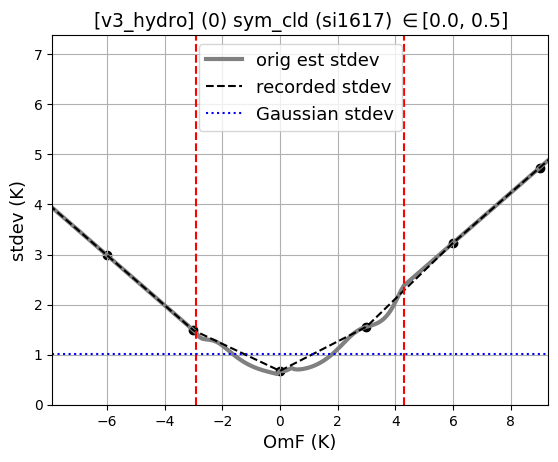

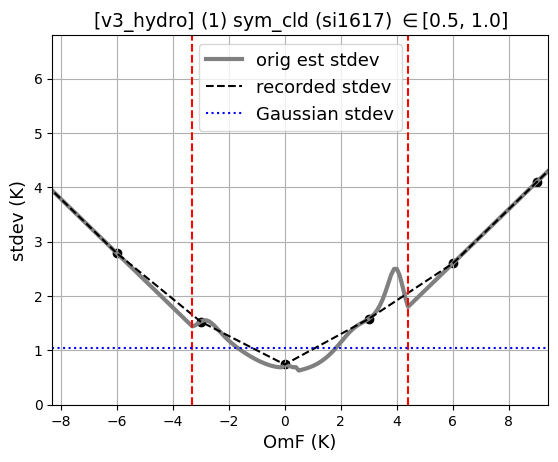

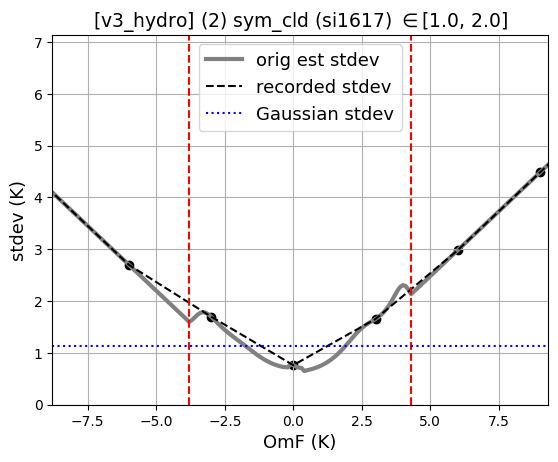

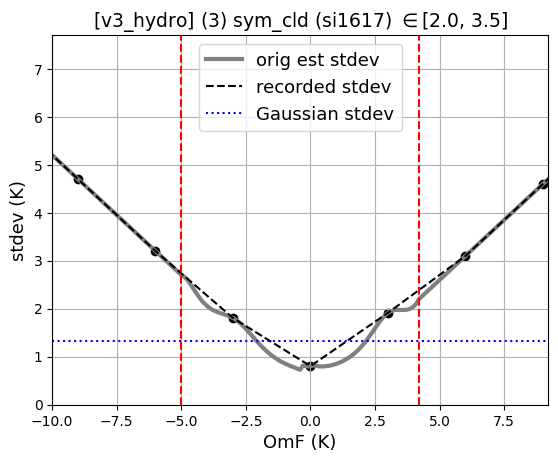

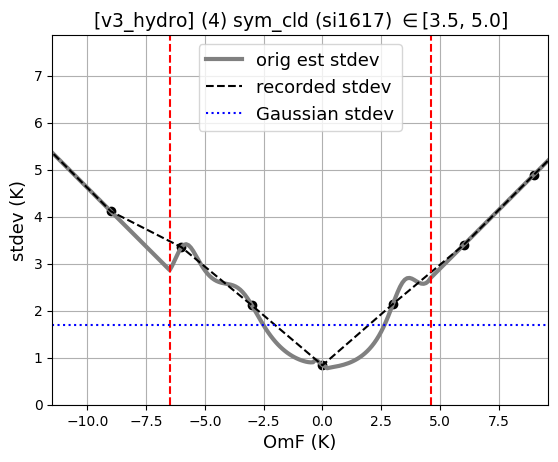

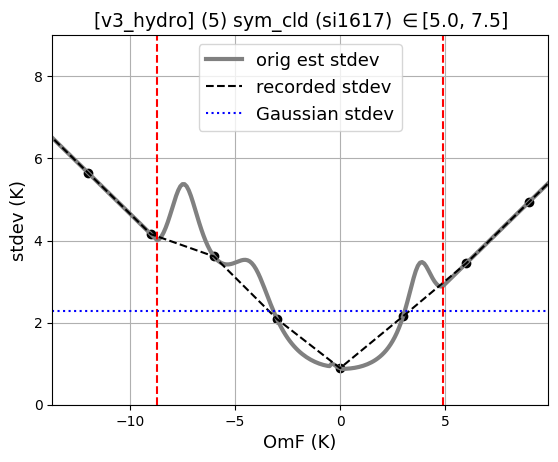

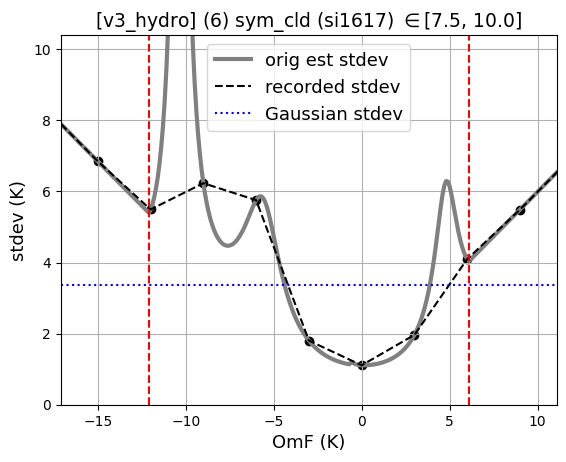

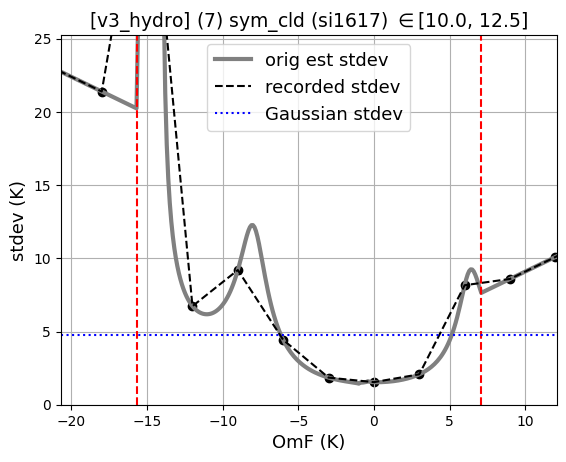

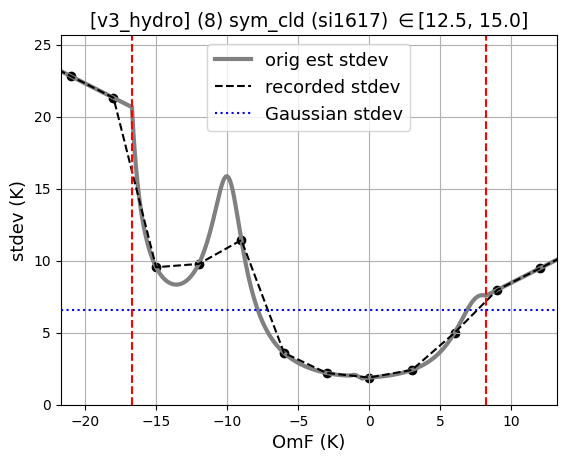

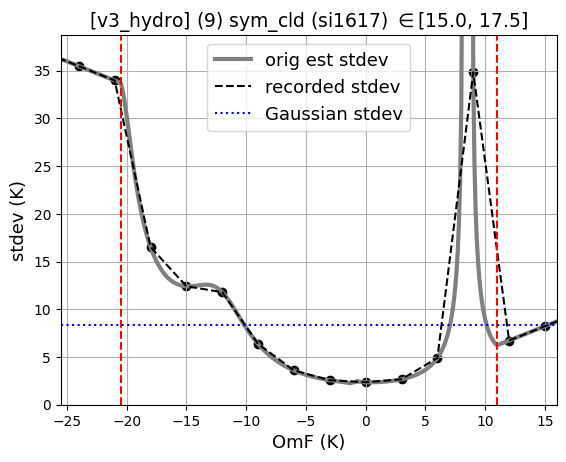

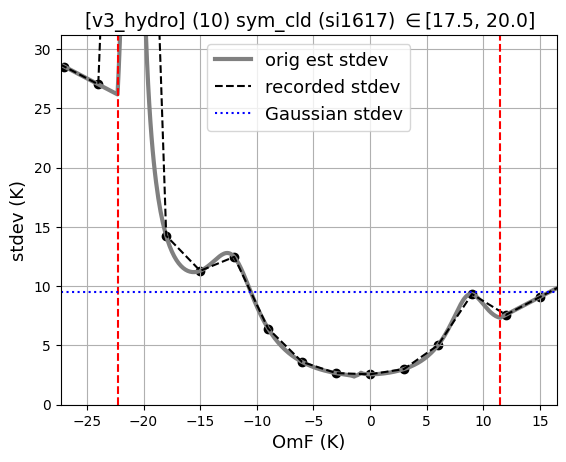

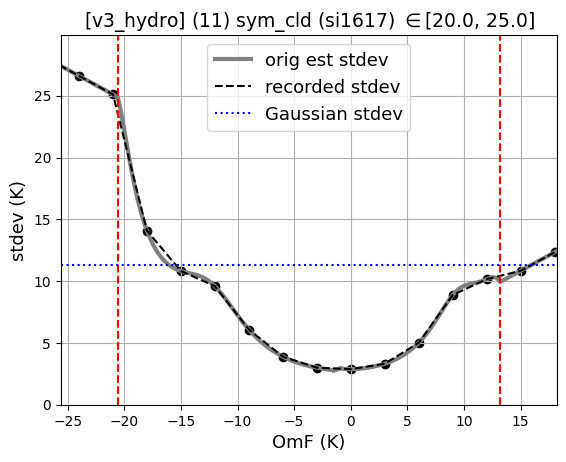

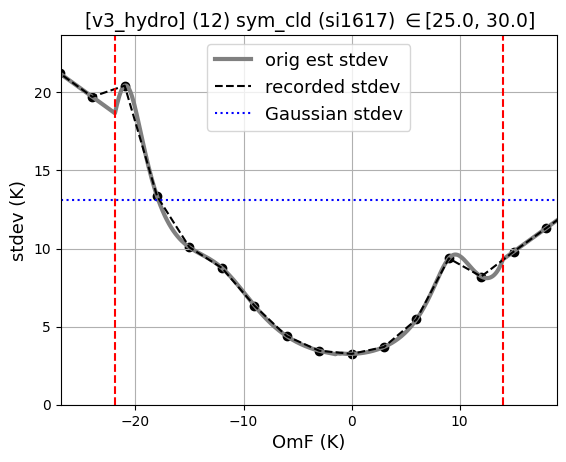

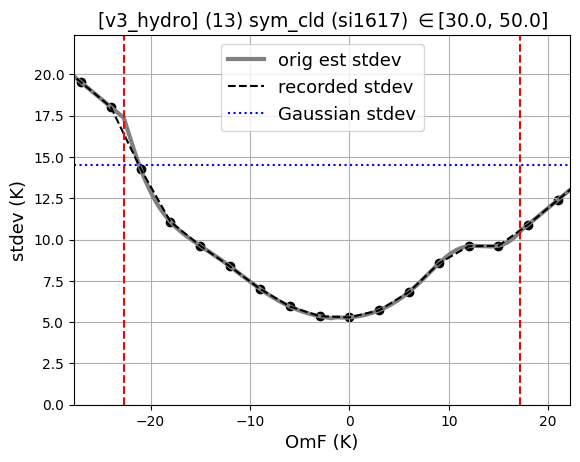

In [33]:
# check if "stdev .vs. omf" looks valid

fig_subdir = f'{fig_dir}/nonGaussian_table/{instrument}/{channel}'
if save_fig:
    os.makedirs(fig_subdir, exist_ok=True)
    print(f"Directory '{fig_subdir}' created.")
    

for i in range(n_cat):
    plt.plot(regrid, nginfo[i]['record_sig'], linewidth=3, color='gray', label='orig est stdev')
    plt.plot(nginfo[i]['coarse_axis'], nginfo[i]['coarse_record_sig'], color='black', linestyle='--', label='recorded stdev')
    plt.scatter(nginfo[i]['coarse_axis'], nginfo[i]['coarse_record_sig'], color='black')

    left_lim  = nginfo[i]['axis_omf'][nginfo[i]['range_min_idx']]
    right_lim = nginfo[i]['axis_omf'][nginfo[i]['range_max_idx']]
    left_std  = nginfo[i]['record_sig'][nginfo[i]['range_min_idx']]
    right_std = nginfo[i]['record_sig'][nginfo[i]['range_max_idx']]
    
    plt.axvline(x=left_lim, color='red', linestyle='--')
    plt.axvline(x=right_lim, color='red', linestyle='--')
    
    plt.axhline(nginfo[i]['stdev'], linestyle=':', color='blue', label='Gaussian stdev')
    
    plt.xlim([left_lim-5, right_lim+5])
    plt.ylim([0, max(left_std, right_std)+5])
    plt.grid(True)
    plt.legend(fontsize=13)
    
    plt.xlabel('OmF (K)',fontsize=13)
    plt.ylabel('stdev (K)'   ,fontsize=13)
    plt.title(rf"[{expid}] ({i}) {predictor} ({cld_pred}) $\in$[{cloud_edge[i]}, {cloud_edge[i+1]}]",fontsize=13.5)

    plt.grid(True)

    if save_fig:
        plt.savefig(f"{fig_subdir}/stdev_table_{expid}_{instrument}_{channel}_{predictor}_{cld_pred}_{cloud_edge[i]}_{cloud_edge[i+1]}.png")    
    
    plt.show() 

In [ ]:
# check if the reconstructed cost-function is similar to the original one

fig_subdir = f'{fig_dir}/recon_pdfs/{instrument}/{channel}'

if save_fig:
    os.makedirs(fig_subdir, exist_ok=True)
    print(f"Directory '{fig_subdir}' created.")
    
for i in range(n_cat):
    plt.plot(nginfo[i]['axis_omf'], nginfo[i]['cost_fn'], linewidth=4, color='gray')
    plt.plot(nginfo[i]['coarse_axis'], nginfo[i]['recon_cost'], linewidth=2, color='blue')

    left_lim   = nginfo[i]['axis_omf'][nginfo[i]['range_min_idx']]
    right_lim  = nginfo[i]['axis_omf'][nginfo[i]['range_max_idx']]
    left_cost  = nginfo[i]['cost_fn'][nginfo[i]['range_min_idx']]
    right_cost = nginfo[i]['cost_fn'][nginfo[i]['range_max_idx']]
    
    plt.axvline(x=left_lim, color='red', linestyle='--')
    plt.axvline(x=right_lim, color='red', linestyle='--')
    
    plt.xlabel('OmF (K)',fontsize=13)
    plt.ylabel('cost'   ,fontsize=13)
    
    plt.xlim([left_lim-10, right_lim+10])
    plt.ylim([0.2, max(left_cost, right_cost)+4])

    plt.title(rf"[{expid}]  {predictor} ({cld_pred}) $\in$[{cloud_edge[i]}, {cloud_edge[i+1]}]",fontsize=13.5)

    plt.grid(True)
    plt.title(f'Symmetric cloud amount = [{cloud_edge[i]}, {cloud_edge[i+1]}]')

    if save_fig:
        plt.savefig(f"{fig_subdir}/reconpdf_{expid}_{instrument}_{channel}_{predictor}_{cld_pred}_{cloud_edge[i]}_{cloud_edge[i+1]}.png")    
    
    plt.show() 

In [ ]:
### save nginfo:
import pickle 
with open(f'{outputdir}/{output_fn}.pkl', 'wb') as f:
    pickle.dump(nginfo, f)

In [ ]:
### save the table

array_values = [float(nginfo[i]['mode']) for i in range(n_cat)]


text_head=f"""nonGaussian observation error table::
!
! only put comment (using !) in this block
!
# instrument    channel       stdev_from        predictor      cloud proxy
#   {instrument}          {channel}        {stdev_from}        {predictor}           {cld_pred}
!
! read the parameters for the table:
! max_range     = the range of OmF pdf in x axis
! dx            = dx in x-axis to define the bin for the OmF pdf
! bdy_slope     = the slope of stdev used to extrapolate to large OmF (larger = inflating more for extreme OmF)
! cri_costfn    = define the boundry of the cost-function that are used to estimate the stdev (not used in GSI code)
! num_cloud_cat = the number of cloud amount categories
! cloud_bin     = the boundary of cloud bins (size = num_cloud_cat +1 )
!
max_range      =  {bdy_regrid:.1f}
dx             =  {coarse_ratio*dx_regrid:.2f}
bdy_slope      =  {extrap_slope}
cri_costfn     =  {10**(-critical_cost_val):.1e}
num_cloud_cat  =  {n_cat}
::

cloud_bin::
{'   '.join('{:.2f}'.format(x) for x in cloud_edge)}
::

bias::
{'   '.join('{:.2f}'.format(x) for x in array_values)}
::

stdev::
"""

output_txt = f'{outputdir}/{output_fn}.txt'


with open(output_txt, 'w') as file:
    file.write(text_head)
    for i in range(n_cat):
        formatted_output = '   '.join('{:.2f}'.format(x) for x in nginfo[i]['coarse_record_sig'])
        file.write(formatted_output + '\n')
    file.write('::')


In [ ]:
# example to read dictionary:
with open('saved_dictionary.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [ ]:
### Polynomial fit to the cost-functions (fixed poly fit)

# Define the polynomial function
def poly_func(x, *coefficients):
    return np.polyval(coefficients[::-1], x)

# Fit a polynomial with a positive constant term
initial_guess = np.ones(poly_dim+1)  # Adjust the length based on the polynomial degree
bounds = (np.full(poly_dim+1, -np.inf), np.full(poly_dim+1, np.inf))  
#bounds[0][-1] = 0

fitted_cost_fn = []
fitted_coeff   = []
for i in range(n_cat):
    
    valid_idx = ~np.isnan(nginfo[i]['cost_fn'])
    coefficients, covariance = curve_fit(poly_func, nginfo[i]['axis_omf'][valid_idx], nginfo[i]['cost_fn'][valid_idx], p0=initial_guess, bounds=bounds)
    tmp = poly_func(regrid, *coefficients)
    tmp[~valid_idx] = np.nan  
    nginfo[i]['fitted_cost_fn'] = tmp
    nginfo[i]['fitted_coeff'] = coefficients